In [1]:
import numpy as np
import pandas as pd
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import cv2

# Dataset functions

In [2]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [3]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
masks_df = pd.read_csv('datasets/airbus-ship-detection/train_ship_segmentations_v2.csv')

For this notebook to work properly unzip the dataset under **datasets** directory

# Creating model with tensorflow

## Working with dataset

In [5]:
masks_df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


Masks are encoded, images are saved separately

In [6]:
side_size = 128 # size of input and output layers of model

### Loading and decoding data into a numpy array

In [7]:
import cv2

def resize_mask(row):  # decodes and resizes masks to side_size by side_size
    
    if row["EncodedPixels"] is np.NaN:
        return np.zeros((side_size, side_size))
    
    mask = row["EncodedPixels"]
    
    np_seg = rle_decode(mask)

    return cv2.resize(np_seg, dsize=(side_size,side_size), interpolation=cv2.INTER_CUBIC)

In [8]:
train_dir = "datasets/airbus-ship-detection/train_v2"
x_train_dir = f"{train_dir}"


def load_resize_image(row): # loads images into the dataframe
    image = cv2.imread(os.path.join(x_train_dir, row["ImageId"]))
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(side_size,side_size), interpolation=cv2.INTER_CUBIC)

    return image

It was decided to limit the amount of data model trains on to minimize time, due to hardware constrains

In [9]:
masks_df_slice = masks_df.dropna()[:40005]
masks_df_slice

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
...,...,...
112893,7c7b9d696.jpg,175494 9 176262 9 177030 9 177798 9 178566 9 1...
112894,7c7b9d696.jpg,122479 22 123225 44 123993 44 124761 44 125529...
112895,7c7b9d696.jpg,432647 1 433414 3 434181 5 434948 7 435715 9 4...
112896,7c7b9d696.jpg,459922 21 460690 21 461458 21 462226 21 462994...


In [10]:
masks_df_slice["decoded_mask"] = masks_df_slice.apply(resize_mask, axis = 1)
masks_df_slice

,ImageId,EncodedPixels,decoded_mask
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...,...
112893,7c7b9d696.jpg,175494 9 176262 9 177030 9 177798 9 178566 9 1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
112894,7c7b9d696.jpg,122479 22 123225 44 123993 44 124761 44 125529...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
112895,7c7b9d696.jpg,432647 1 433414 3 434181 5 434948 7 435715 9 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
112896,7c7b9d696.jpg,459922 21 460690 21 461458 21 462226 21 462994...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [11]:
grouped = masks_df_slice.drop("EncodedPixels", axis = 1).groupby("ImageId").sum()
grouped

,decoded_mask
ImageId,
000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00021ddc3.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
0002756f7.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
00031f145.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...
7c7852de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7c792f1d9.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
7c798bdf8.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [12]:
grouped = grouped.reset_index()
grouped

,ImageId,decoded_mask
0,000155de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,000194a2d.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,00021ddc3.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,0002756f7.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,00031f145.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
20727,7c7852de5.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20728,7c792f1d9.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20729,7c798bdf8.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
20730,7c7a5fa63.jpg,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
grouped["gr_image"] = grouped.apply(load_resize_image, axis = 1)

Resulting 20732 photos that will be used in training

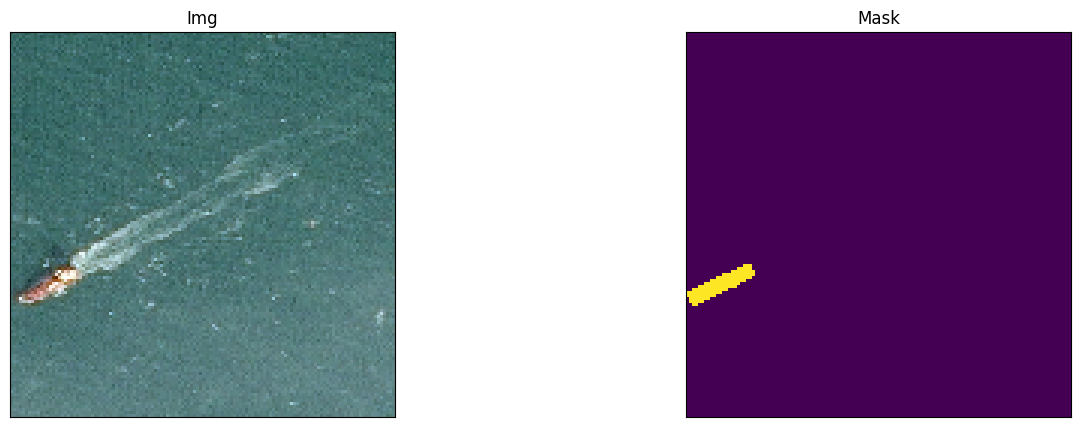

In [14]:
visualize(img = grouped.loc[745, "gr_image"], mask = grouped.loc[745, "decoded_mask"])  # demonstraiting a sample from dataset

In [15]:
grouped.to_csv("grouped_masked_loaded.csv")  # save formated dataset for future use

In [16]:
xy_train = grouped[["gr_image", "decoded_mask"]].sample(frac=0.8,random_state=200) # split dataset into train and test sets, split is 80/20
xy_test = grouped[["gr_image", "decoded_mask"]].drop(xy_train.index)

x_train = xy_train.drop("decoded_mask", axis = 1)
x_test= xy_test.drop("decoded_mask", axis = 1)

y_train = xy_train[["decoded_mask"]]
y_test= xy_test[["decoded_mask"]]

In [17]:
y_train_numpy = np.stack(y_train[["decoded_mask"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
y_train_numpy = y_train_numpy.reshape(*y_train_numpy.shape, 1) # transform it into 4d array for model compatability
y_train_numpy.shape

(16586, 128, 128, 1)

In [18]:
x_train_numpy = np.stack(x_train[["gr_image"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
x_train_numpy.shape

(16586, 128, 128, 3)

In [19]:
y_test_numpy = np.stack(y_test[["decoded_mask"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
y_test_numpy = y_test_numpy.reshape(*y_test_numpy.shape, 1) # transform it into 4d array for model compatability
y_test_numpy.shape

(4146, 128, 128, 1)

In [20]:
x_test_numpy = np.stack(x_test[["gr_image"]].values.flatten()) # transform dataframe of numpy arrays into 3d numpy array
x_test_numpy.shape

(4146, 128, 128, 3)

## Train the model

In [21]:
import tensorflow as tf
import keras

In [22]:
def get_model(img_sizem ,num_classes):
  """
  This function will define the U-net model
  """
  # define the input layer
  input_layer = keras.layers.Input(shape=img_sizem + (3, ))

  # Rescaling layer
  rescaling = keras.layers.Rescaling(1. / 255)(input_layer) # rescale input images to [0, 1]

  # define convolution layers (Downward)
  x = keras.layers.Conv2D(64, 3, padding="same", activation="relu", strides=2)(rescaling)
  x = keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
  x = keras.layers.Conv2D(128, 3, padding="same", activation="relu", strides=2)(x)
  x = keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
  x = keras.layers.Dropout(0.01)(x)

  # define Transpose layers (Upward)
  y = keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu")(x)
  y = keras.layers.Conv2DTranspose(128, 3, padding="same", activation="relu", strides=2)(y)
  y = keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu")(y)
  y = keras.layers.Conv2DTranspose(64, 3, padding="same", activation="relu", strides=2)(y)
  y = keras.layers.Dropout(0.01)(y)

  # define the output layer
  output_layer = keras.layers.Conv2D(num_classes, 3, padding="same", activation="sigmoid")(y)

  # create the model
  model = keras.models.Model(input_layer, output_layer)

  return model

In [23]:
segmentation_model = get_model((side_size, side_size), 1)

In [24]:
segmentation_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,625 (2.54 MB)

 Trainable params: 666,625 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# compile the model
segmentation_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy()])

In [26]:
callbacks = [keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True)]

In [28]:
history = segmentation_model.fit(x_train_numpy, y_train_numpy, epochs=2, batch_size=128, validation_data=(x_test_numpy, y_test_numpy), callbacks=callbacks)

Epoch 1/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 743s 6s/step - binary_accuracy: 0.9949 - loss: 0.0394 - val_binary_accuracy: 0.9948 - val_loss: 0.0254
Epoch 2/2
130/130 ━━━━━━━━━━━━━━━━━━━━ 743s 6s/step - binary_accuracy: 0.9949 - loss: 0.0225 - val_binary_accuracy: 0.9948 - val_loss: 0.0162


In [29]:
segmentation_model.save("segmentation_model.keras")

In [30]:
res = segmentation_model.evaluate(x_test_numpy, y_test_numpy)

130/130 ━━━━━━━━━━━━━━━━━━━━ 32s 242ms/step - binary_accuracy: 0.9948 - loss: 0.0162


In [ ]:
test_image = 2001


visualize(img = x_test_numpy[test_image], mask = y_test_numpy[test_image], predicted = segmentation_model.predict(x_test_numpy[test_image].reshape(1, 128, 128, 3)).reshape(128, 128))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Resulting model shows great results in ship designation on seas while requiring little to no training and time to run